In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

fig.initialize()

import foundation as fd
from foundation import models
from foundation import util
from foundation.data import Intervention_Sampler

from sklearn.decomposition import PCA
import sklearn.datasets

from sae_src import sample_full_interventions, response_mat, factor_reponses

# import gpumap
from c3linearize import linearize, class_graph

In [20]:
names = '''3ds_ae0_e-c12_d-c12_210125-045343
3ds_ae0_e-c12_d-c12_mish_210125-050038
3ds_ae0_e-c12_d-s12_210125-045438
3ds_ae0_e-c12_d-s12_mish_210125-050335
3ds_ae0_e-c12_d-s12_nosplit_210125-045438
3ds_ae0_e-c12_d-s2_210125-132645
3ds_ae0_e-c12_d-s3_210125-134123
3ds_ae0_e-c12_d-s4_seed2_210125-133117
3ds_ae0_e-c12_d-s6_lrp0004_210125-171518
3ds_vae2_e-c12_d-c12_210125-045344
3ds_vae2_e-c12_d-c12_mish_210125-140255
3ds_wae1000_e-c12_d-c12_210125-221143
3ds_wae100_e-c12_d-c12_210125-221143
3ds_vae1_e-c12_d-c12_210125-045347
3ds_vae1_e-l12_d-l12_210125-045439
3ds_vae1_e-c12_d-c12_mish_210125-140254
3ds_vae1_e-l12_d-l12_mish_210125-140249'''.split('\n')
len(names)

17

In [21]:
device = 'cuda'

In [22]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\trained_nets')
run_names = os.listdir(str(root))
len(run_names)

238

In [23]:
def _load_run(name):
    load_config = fig.get_config(path=name, root=str(root), **{'override.device':device})
    load_config.set_silent(True)
    run = fig.run('load-run', load_config)
    return run

In [24]:
runs = [_load_run(name) for name in names]
len(runs)

Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-c12_210125-045343\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-c12_mish_210125-050038\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s12_210125-045438\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s12_mish_210125-050335\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s12_nosplit_210125-045438\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s2_210125-132645\config.yaml


Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s3_210125-134123\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s4_seed2_210125-133117\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s6_lrp0004_210125-171518\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae2_e-c12_d-c12_210125-045344\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae2_e-c12_d-c12_mish_210125-140255\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_wae1000_e-c12_d-c12_210125-221143\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_wae100_e-c12_d-c12_210125-221143\config.yaml


Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae1_e-c12_d-c12_210125-045347\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae1_e-l12_d-l12_210125-045439\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae1_e-c12_d-c12_mish_210125-140254\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae1_e-l12_d-l12_mish_210125-140249\config.yaml


17

In [25]:
full = {}
for run in runs:
    full[run.get_name()] = run.get_results('responses')
len(full)

17

In [26]:
full[run.get_name()]['scores']['responses']['disentanglement'].item()

0.9029592275619507

In [27]:
dis = {name: val['scores']['responses']['disentanglement'].item() for name, val in full.items()}
dis

{'3ds_ae0_e-c12_d-c12_210125-045343': 0.42171812057495117,
 '3ds_ae0_e-c12_d-c12_mish_210125-050038': 0.46293771266937256,
 '3ds_ae0_e-c12_d-s12_210125-045438': 0.927747368812561,
 '3ds_ae0_e-c12_d-s12_mish_210125-050335': 0.9850431084632874,
 '3ds_ae0_e-c12_d-s12_nosplit_210125-045438': 0.4851328134536743,
 '3ds_ae0_e-c12_d-s2_210125-132645': 0.6679278016090393,
 '3ds_ae0_e-c12_d-s3_210125-134123': 0.72877436876297,
 '3ds_ae0_e-c12_d-s4_seed2_210125-133117': 0.7457446455955505,
 '3ds_ae0_e-c12_d-s6_lrp0004_210125-171518': 0.8022826313972473,
 '3ds_vae2_e-c12_d-c12_210125-045344': 0.9558988213539124,
 '3ds_vae2_e-c12_d-c12_mish_210125-140255': 0.6085110306739807,
 '3ds_wae1000_e-c12_d-c12_210125-221143': 0.4580004811286926,
 '3ds_wae100_e-c12_d-c12_210125-221143': 0.4243032932281494,
 '3ds_vae1_e-c12_d-c12_210125-045347': 0.678819477558136,
 '3ds_vae1_e-l12_d-l12_210125-045439': 0.8798182606697083,
 '3ds_vae1_e-c12_d-c12_mish_210125-140254': 0.6777613162994385,
 '3ds_vae1_e-l12_d-l12_m

In [31]:
runs[0].get_config().pull('info', silent=True)

{'arch_type': 'c12',
 'dataset_type': '3ds',
 'dec_type': 'c12',
 'enc_type': 'c12',
 'model_type': 'ae',
 'size': 64}

In [32]:
infos = {run.get_name():run.get_config().pull('info', silent=True) for run in runs}
len(infos)

17

In [52]:
titles = {name: '{} {}{}'.format(info['model_type'].upper(), info['dec_type'].upper(), ' mish' if 'mish' in name else '') for name, info in infos.items()}
len(titles)

17

In [53]:
keys = list(titles.keys())
keys = sorted(keys)
x = [titles[n] for n in keys]
y = [dis[n] for n in keys]
len(x), len(y)

(17, 17)

<IPython.core.display.Javascript object>


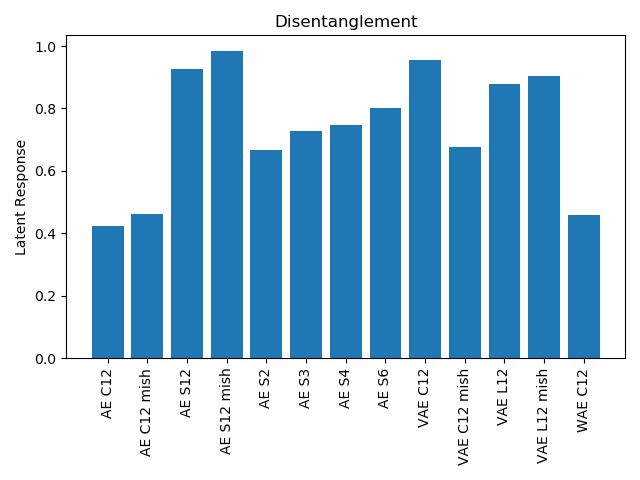

In [55]:
plt.bar(x, y);
plt.xticks(rotation='vertical');
plt.title('Disentanglement')
plt.ylabel('Latent Response')
plt.tight_layout();

In [3]:
run = fig.quick_run('load-run', path=r'C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s2_nosplit_210125-134343')

| [Pushed] _type: 'run'
| CREATING . (type=run)
|  > silent: False (by default)
|  > invisible: False (by default)
|  > path: 'C:\\Users\\anwan\\Documents\\workspace\\sae\\trained_nets\\3ds_ae0_e-c12_d-s2_nosplit_210125-134343'
|  > [Pushed] novel: False
|  > override: [<class 'dict'>] (by default)
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s2_nosplit_210125-134343\config.yaml
|  > [Pushed] path: 'C:\\Users\\anwan\\Documents\\workspace\\sae\\trained_nets\\3ds_ae0_e-c12_d-s2_nosplit_210125-134343'
|  > ckpt-num: None (by default)
|  > best: False (by default)
|  > last: True (by default)
|  > [Pushed] dataset._load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\sae\\trained_nets\\3ds_ae0_e-c12_d-s2_nosplit_210125-134343\\ckpt100000'
|  > [Pushed] model._load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\sae\\trained_nets\\3ds_ae0_e-c12_d-s2_nosplit_210125-134343\\ckpt100000'
|  > [Pushed] records._load-ckpt: 'C:\\Users\\anwan\\Document

In [5]:
e = run.get_results('eval')
e.keys()

odict_keys(['device', 'original', 'batch', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs', 'rec_fid_stats', 'rec_fid', 'hybrid_fid_stats', 'hybrid_fid'])

In [6]:
e['diffs'].shape

torch.Size([16, 12])

In [8]:
f = run.get_results('final-test')
f.keys()

odict_keys(['device', 'original', 'batch', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs', 'rec_fid_stats', 'rec_fid', 'hybrid_fid_stats', 'hybrid_fid'])

In [12]:
f['rec_fid']

0.03641091961960541